In [1]:
import glob
import numpy as np
import pandas as pd
from skimage.io import imread, imread_collection
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Carregando as imagens da base
negativo = glob.glob('leishmaniose/Negativo/*.jpg')
positivo = glob.glob('leishmaniose/Positivo/*.jpg')

imagens = imread_collection(negativo+positivo)

In [47]:
# 4 imagens aleatórias
plot = imagens[1], imagens[9], imagens[100], imagens[115]

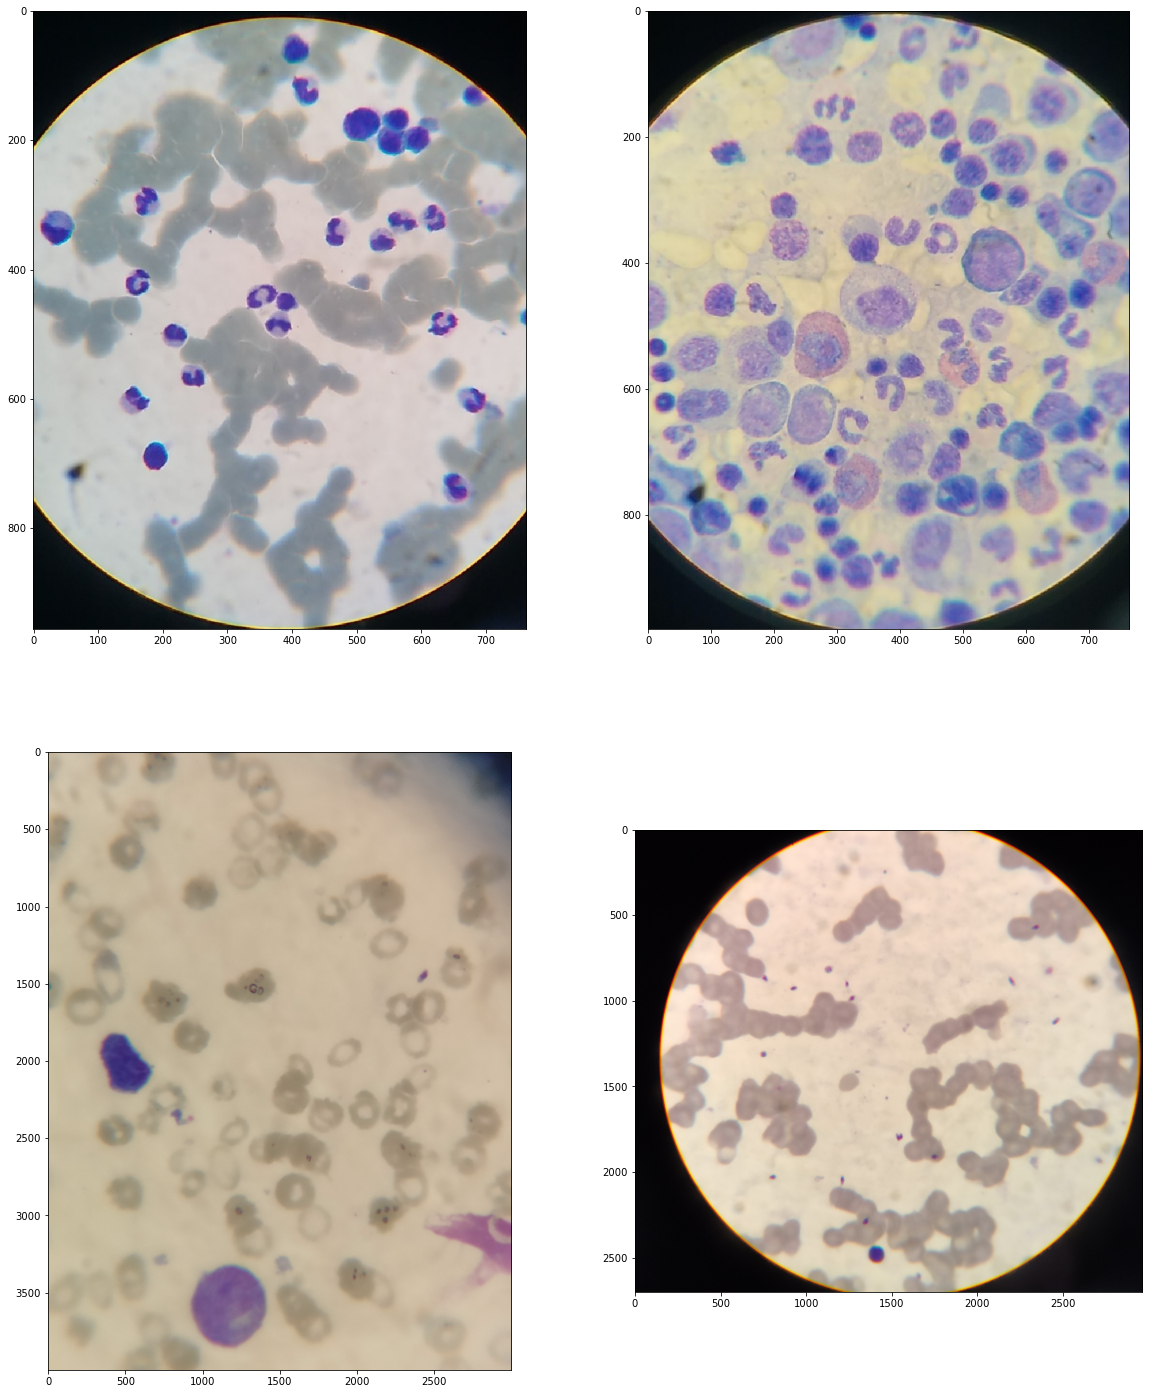

In [48]:
def exibe_imagens(imgs):
    fig, ax = plt.subplots(2, 2, figsize=(20, 25))
    ax = ax.ravel()

    for i in range(len(imgs)):
        ax[i].imshow(imgs[i], cmap="gray")
        
exibe_imagens(plot)

In [4]:
labels = np.concatenate((np.zeros(len(negativo)), np.ones(len(positivo))))
labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

# Descritores
- GLCM
- HOG 
- CNN

# 1. Extraindo características com o descritor GLCM

(-0.5, 600.5, 400.5, -0.5)

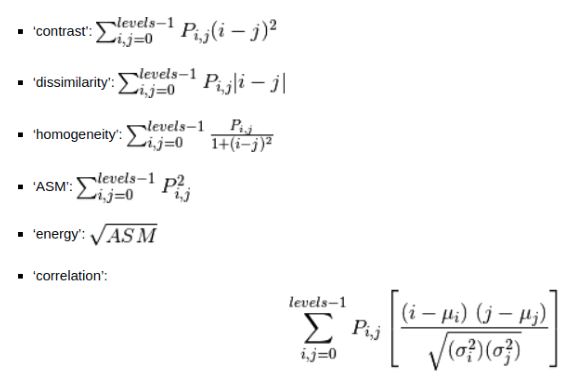

In [5]:
imagem_glcm = imread('GLCM.png')
plt.figure(figsize=(10,10))
plt.imshow(imagem_glcm)
plt.axis('off')

* Contraste: Mede as variações locais na matriz de coocorrência de níveis de cinza.
* Correlação: Mede a ocorrência de probabilidade conjunta dos pares de pixels especificados.
* Energia: Fornece a soma dos elementos quadrados no GLCM. Também conhecido como uniformidade ou segundo momento angular.
* Homogeneidade: Mede a proximidade da distribuição dos elementos no GLCM à diagonal do GLCM.

In [6]:
d = 1

In [7]:
from skimage.feature import greycomatrix,greycoprops

features = np.zeros((len(labels), 18)) # 6 features x 3 canais de cor
start = time.time()

for id_im, imagem in enumerate(imagens):
    clear_output(wait=True)
    print('Extraindo atributos: {} imagens processadas de {}.'.format(id_im+1, len(imagens)))
    for id_ch in range(3):
        
        # Extrai características em todos os ângulos
        matrix0 = greycomatrix(imagem[:,:,id_ch], [d], [0],normed=True)
        matrix1 = greycomatrix(imagem[:,:,id_ch], [d], [np.pi/4],normed=True)
        matrix2 = greycomatrix(imagem[:,:,id_ch], [d], [np.pi/2],normed=True)
        matrix3 = greycomatrix(imagem[:,:,id_ch], [d], [3*np.pi/4],normed=True)
        matrix = (matrix0+matrix1+matrix2+matrix3)/4 
        
        
        # Insere as características na matriz features
        props = np.zeros((6))
        props[0] = greycoprops(matrix,'contrast')
        props[1] = greycoprops(matrix,'dissimilarity')
        props[2] = greycoprops(matrix,'homogeneity')
        props[3] = greycoprops(matrix,'energy')
        props[4] = greycoprops(matrix,'correlation')
        props[5] = greycoprops(matrix,'ASM')
        features[id_im,id_ch*6:(id_ch+1)*6] = props

end = time.time()
print('time = ', end - start)

Extraindo atributos: 151 imagens processadas de 151.
time =  30.49849271774292


## 1.1 Visualização dos atributos

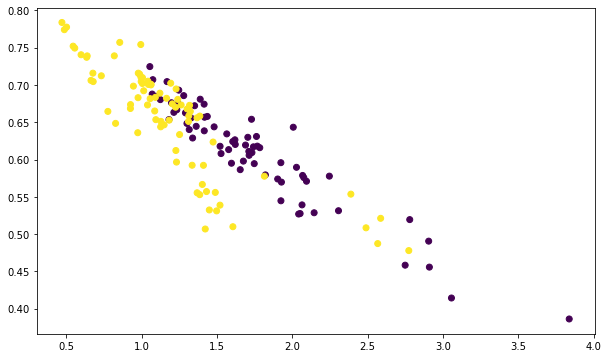

In [8]:
fig = plt.figure(figsize=(10,6))
plt.scatter(features[:,1],features[:,2], c=labels)

In [9]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(features)
transform = pca.transform(features)
print(np.sum(pca.explained_variance_ratio_[0:3]))

0.9994852946534549


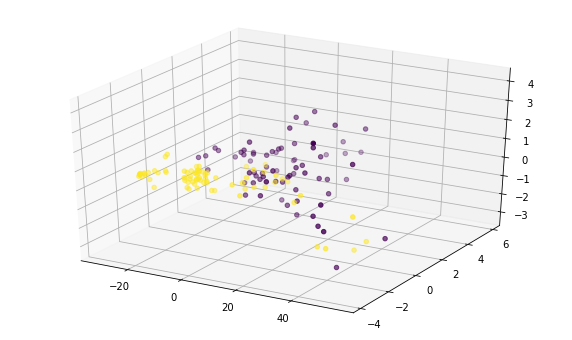

In [10]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(transform[:,0],transform[:,1], transform[:,2], c=labels)

## 1.2. Classificação

### 1.2.1 Métricas
- acuracia
- precision
- recall
- f1score
- kappa

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# Calculo de métricas
def calculo_metricas(y_true, y_pred):    
    
    acuracia = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1score = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    
    metricas = list(np.round([acuracia, precision, recall, f1score, kappa], 4))
    
    return metricas

### 1.2.2 Classificadores
- Random Forest
- SVM
- XGBooster
- MLP

In [12]:
from sklearn.ensemble import RandomForestClassifier

# RandomForest
def classificador_randomForest(X_train, X_test, y_train, y_test):
    
    c_rf = RandomForestClassifier(random_state = 1, n_jobs = -1, n_estimators = 1000)
    c_rf.fit(X_train, y_train)
    pred = c_rf.predict(X_test)
    
    return y_test, pred

In [13]:
from sklearn import svm

# SVM
def classificador_svm(X_train, X_test, y_train, y_test):
    
    c_svm = svm.SVC(random_state = 1)
    c_svm.fit(X_train, y_train)
    pred = c_svm.predict(X_test)
    
    return y_test, pred

In [14]:
from xgboost import XGBClassifier

# XGBooster
def classificador_xgbooster(X_train, X_test, y_train, y_test):
    
    c_xgb = XGBClassifier(random_state = 1, n_jobs = -1, n_estimators = 1000, eval_metric='mlogloss')
    c_xgb.fit(X_train, y_train)
    pred = c_xgb.predict(X_test)
    
    return y_test, pred

In [15]:
from sklearn.neural_network import MLPClassifier

# MLP
def classificador_mlp(X_train, X_test, y_train, y_test):
    
    c_mlp = MLPClassifier(random_state=1, hidden_layer_sizes=(100,100), max_iter=1000)
    c_mlp.fit(X_train, y_train)
    pred = c_mlp.predict(X_test)
    
    return y_test, pred

### 1.2.3 Divisão em treino e teste

In [16]:
treino = 0.8
teste = 1 - treino

In [17]:
from sklearn.model_selection import train_test_split

def divisao_treino_teste():

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=teste)
    X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(transform, labels, test_size=teste)

    print('Imagens treino = ', len(X_train))
    print('Imagens teste = ', len(X_test))
    
    return X_train, X_test, y_train, y_test, X_train_pca, X_test_pca, y_train_pca, y_test_pca

In [18]:
X_train, X_test, y_train, y_test, X_train_pca, X_test_pca, y_train_pca, y_test_pca = divisao_treino_teste()

Imagens treino =  120
Imagens teste =  31


### 1.2.4 Executando classificadores

In [19]:
0.3f# Execução dos classificadores
def executa_classificadores_all_features(X_train, X_test, y_train, y_test):
    print("Métricas: [Acurácia, Precision, Recall, F1-score, Kappa]\n\n")
    print("====== Utilizando todas as features ======\n")

    print("--------------- Random Forest ----------------")
    y_test, pred = classificador_randomForest(X_train, X_test, y_train, y_test)
    print("Métricas: ", calculo_metricas(y_test, pred))

    print("\n------------------ SVM ---------------------")
    y_test, pred = classificador_svm(X_train, X_test, y_train, y_test)
    print("Métricas: ", calculo_metricas(y_test, pred))

    print("\n--------------- XGBooster ------------------")
    y_test, pred = classificador_xgbooster(X_train, X_test, y_train, y_test)
    print("Métricas: ", calculo_metricas(y_test, pred))

    print("\n--------------- MLP ------------------")
    y_test, pred = classificador_mlp(X_train, X_test, y_train, y_test)
    print("Métricas: ", calculo_metricas(y_test, pred))

In [20]:
executa_classificadores_all_features(X_train, X_test, y_train, y_test)

Métricas: [Acurácia, Precision, Recall, F1-score, Kappa]


====== Utilizando todas as features ======

--------------- Random Forest ----------------
Métricas:  [0.8065, 0.8333, 0.7143, 0.7692, 0.6043]

------------------ SVM ---------------------
Métricas:  [0.7742, 0.7333, 0.7857, 0.7586, 0.547]

--------------- XGBooster ------------------
Métricas:  [0.7419, 0.7143, 0.7143, 0.7143, 0.479]

--------------- MLP ------------------
Métricas:  [0.8387, 1.0, 0.6429, 0.7826, 0.6638]


In [21]:
n_components = 5

print("Métricas: [Acurácia, Precision, Recall, F1-score, Kappa]\n\n")
print("=== Utilizando utilizando {} componentes PCA ===\n".format(n_components))

print("--------------- Random Forest ----------------")
y_test_pca, pred = classificador_randomForest(X_train_pca[:,0:n_components], X_test_pca[:,0:n_components], y_train_pca, y_test_pca)
print("Métricas: ", calculo_metricas(y_test_pca, pred))

print("\n------------------ SVM ---------------------")
y_test_pca, pred = classificador_svm(X_train_pca[:,0:n_components], X_test_pca[:,0:n_components], y_train_pca, y_test_pca)
print("Métricas: ", calculo_metricas(y_test_pca, pred))

print("\n--------------- XGBooster ------------------")
y_test_pca, pred = classificador_xgbooster(X_train_pca[:,0:n_components], X_test_pca[:,0:n_components], y_train_pca, y_test_pca)
print("Métricas: ", calculo_metricas(y_test_pca, pred))

print("\n--------------- MLP ------------------")
y_test_pca, pred = classificador_mlp(X_train_pca[:,0:n_components], X_test_pca[:,0:n_components], y_train_pca, y_test_pca)
print("Métricas: ", calculo_metricas(y_test_pca, pred))

Métricas: [Acurácia, Precision, Recall, F1-score, Kappa]


=== Utilizando utilizando 5 componentes PCA ===

--------------- Random Forest ----------------
Métricas:  [0.7419, 0.8889, 0.5333, 0.6667, 0.4768]

------------------ SVM ---------------------
Métricas:  [0.6774, 0.7273, 0.5333, 0.6154, 0.3487]

--------------- XGBooster ------------------
Métricas:  [0.7742, 0.8333, 0.6667, 0.7407, 0.5451]

--------------- MLP ------------------
Métricas:  [0.7419, 0.8182, 0.6, 0.6923, 0.479]


#### 1.2.4.1 Média e desvio padrão

In [22]:
n = 100
acc, pre, rec, f1, k = [], [], [], [], []

for i in range(n):
    clear_output(wait=True)
    print('Iteração {} de {}.'.format(i+1,n))

    # Nova divisão dos dados
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=teste)
    
    # XGBooster
    y_test, pred = classificador_mlp(X_train, X_test, y_train, y_test)
    metricas = calculo_metricas(y_test, pred)
    acc.append(metricas[0])
    pre.append(metricas[1])
    rec.append(metricas[2])
    f1.append(metricas[3])
    k.append(metricas[4])

print("\n=== Utilizando todas as features na MLP ===")
print("Mean Acurácia: {}+-{}".format(np.mean(acc), np.std(acc)))
print("Mean Precision: {}+-{}".format(np.mean(pre), np.std(pre)))
print("Mean Recall: {}+-{}".format(np.mean(rec), np.std(rec)))
print("Mean F1-score: {}+-{}".format(np.mean(f1), np.std(f1)))
print("Mean Kappa: {}+-{}".format(np.mean(k), np.std(k)))

Iteração 100 de 100.

=== Utilizando todas as features na MLP ===
Mean Acurácia: 0.8442029999999998+-0.06018183522459247
Mean Precision: 0.861815+-0.07461410640756881
Mean Recall: 0.8447970000000001+-0.09615861839169695
Mean F1-score: 0.84871+-0.06339672625617193
Mean Kappa: 0.682064+-0.12370190258844041


In [23]:
n = 100
n_components = 10
acc_pca, pre_pca, rec_pca, f1_pca, k_pca = [], [], [], [], []

for i in range(n):
    clear_output(wait=True)
    print('Iteração {} de {}.'.format(i+1,n))
    
    # Nova divisão dos dados
    X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(transform[:,0:n_components], labels, test_size=teste)
    
    # XGBooster
    y_test_pca, pred = classificador_xgbooster(X_train_pca, X_test_pca, y_train_pca, y_test_pca)
    metricas = calculo_metricas(y_test_pca, pred)
    acc_pca.append(metricas[0])
    pre_pca.append(metricas[1])
    rec_pca.append(metricas[2])
    f1_pca.append(metricas[3])
    k_pca.append(metricas[4])
    
print("\n=== Utilizando {} componentes PCA no XGBooster ===".format(n_components))    
print("Mean Acurácia: {}+-{}".format(np.mean(acc_pca), np.std(acc_pca)))
print("Mean Precision: {}+-{}".format(np.mean(pre_pca), np.std(pre_pca)))
print("Mean Recall: {}+-{}".format(np.mean(rec_pca), np.std(rec_pca)))
print("Mean F1-score: {}+-{}".format(np.mean(f1_pca), np.std(f1_pca)))
print("Mean Kappa: {}+-{}".format(np.mean(k_pca), np.std(k_pca)))

Iteração 100 de 100.

=== Utilizando 10 componentes PCA no XGBooster ===
Mean Acurácia: 0.853554+-0.06457831434777467
Mean Precision: 0.8711840000000001+-0.089451471446813
Mean Recall: 0.843501+-0.09927959457511902
Mean F1-score: 0.8515980000000001+-0.07096819002905456
Mean Kappa: 0.703395+-0.12964921625293382


# 2. Extraindo características com o descritor HOG

In [24]:
from skimage.feature import hog
from skimage import feature, transform

features = np.zeros((len(labels), 53792))
start = time.time()

for id_im, imagem in enumerate(imagens):
    clear_output(wait=True)
    print('Extraindo atributos: {} imagens processadas de {}.'.format(id_im+1, len(imagens)))

    # Extrai características
    grayim = rgb2gray(imagem)
    grayim = transform.resize(grayim,(330,330))

    fd = feature.hog(grayim, orientations=8, pixels_per_cell=(4, 4), cells_per_block=(1, 1), transform_sqrt=True)
    features[id_im,:] = fd

end = time.time()
print('time = ', end - start)

Extraindo atributos: 151 imagens processadas de 151.
time =  86.94575691223145


In [25]:
features.shape

(151, 53792)

### 2.1 Visualização dos dados

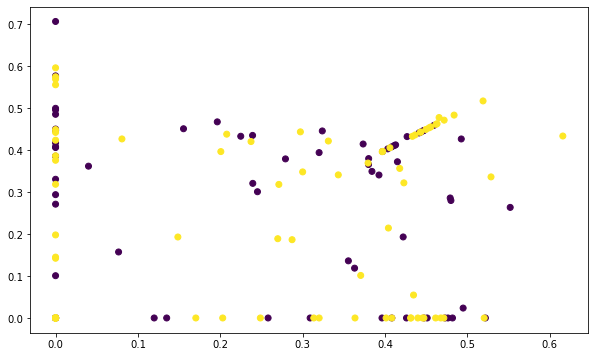

In [26]:
fig = plt.figure(figsize=(10,6))
plt.scatter(features[:,1],features[:,2], c=labels)

### 2.2 Divisão em treino e teste

In [39]:
# Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=teste)

### 2.3 Execução dos classificadores

In [40]:
executa_classificadores_all_features(X_train, X_test, y_train, y_test)

Métricas: [Acurácia, Precision, Recall, F1-score, Kappa]


====== Utilizando todas as features ======

--------------- Random Forest ----------------
Métricas:  [0.7419, 0.9167, 0.6111, 0.7333, 0.502]

------------------ SVM ---------------------
Métricas:  [0.7742, 1.0, 0.6111, 0.7586, 0.5686]

--------------- XGBooster ------------------
Métricas:  [0.7097, 0.8462, 0.6111, 0.7097, 0.4341]

--------------- MLP ------------------
Métricas:  [0.8065, 1.0, 0.6667, 0.8, 0.6265]
